In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt

colors = viz.plotting_style()
lin_colors = colors.values()

plt.style.use('style.mpl')


In [2]:
# Load the data for the NOSC correlation figure
# Description of the bac120 genes
bac120_meta_df = pd.read_csv('../data/gtdb/r207/bac120_msa_marker_info_r207_annot.csv',
                             index_col=0)

# Read the NOSC values for bac120 as a wide-form matrix
bac120_nosc_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_vals_wide.csv', index_col=0)

# Read the correlation matrix for bac120 -- raw correlations first
nosc_corr_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_corr.csv', index_col=[0,1])
# Correlations controlled for mean genome NOSC
nosc_corr_controlled_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_corr_controlled_for_genome_nosc.csv', index_col=[0,1])

In [3]:
# Load the output from optimization runs where ZCred and ZCB are both varied
var_ZCB_df = pd.read_csv('../output/Fig3C_variable_ZCorg_var_ZCB.csv')
# Mask out the values computed without ATP homeostasis
tmp = var_ZCB_df[var_ZCB_df['opt.max_phi_H_set'] == False]

# Make a matrix of the maximum growth rate values for each pair of (ZCred,ZCB)
ZCred_ZCB_lambda_mat = tmp.pivot_table(index='ZCorg', columns='ZCB', values='lambda_hr')

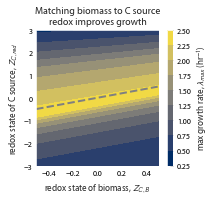

In [4]:
plt.figure(figsize=(2.75,2.5))
plt.contourf(ZCred_ZCB_lambda_mat.columns,
             ZCred_ZCB_lambda_mat.index,
             ZCred_ZCB_lambda_mat.values,
             cmap='cividis')
plt.colorbar(label='max growth rate, $\lambda_{max}$ (hr$^{-1}$)')

xs = np.arange(ZCred_ZCB_lambda_mat.columns.min(), ZCred_ZCB_lambda_mat.columns.max(), 0.01)
plt.plot(xs, xs, ls='--', color='grey')
plt.xlabel('redox state of biomass, $Z_{C,B}$')
plt.ylabel('redox state of C source, $Z_{C,red}$')
plt.title('Matching biomass to C source\nredox improves growth')
plt.savefig('../output/Fig4A.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

0.7932624352511349 ile tRNA syn. ser tRNA syn.
0.4095090511505405 FtsY RadA
0.2022310253031126 RplO PPAT
0.0175372666307355 SecG RecA


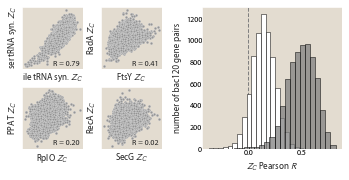

In [5]:
fig = plt.figure(figsize=(5, 2.6))
subfigs = fig.subfigures(nrows=1, ncols=2)
galleryAxs = subfigs[0].subplots(nrows=2, ncols=2)
axRight = subfigs[1].subplots(nrows=1, ncols=1)

pairs = ["TIGR00392,TIGR00414".split(','), "TIGR00064,TIGR00416".split(','),
         "TIGR01071,TIGR01510".split(','), 'TIGR00810,TIGR02012'.split(',') ]
pnames_dict = {
    'TIGR00392': 'ile tRNA syn.',
    'TIGR00414': 'ser tRNA syn.',
    'TIGR00810': 'SecG',
    'TIGR02012': 'RecA',
    'TIGR00064': 'FtsY',
    'TIGR00416': 'RadA',
    'TIGR01071': 'RplO',
    'TIGR01510': 'PPAT',  # pantetheine-phosphate adenylyltransferase
}
greys = sns.color_palette('Greys', n_colors=5)
for ax, gene_ids in zip(galleryAxs.flatten('C'), pairs):
    plt.sca(ax)

    sns.scatterplot(data=bac120_nosc_df, x=gene_ids[0], y=gene_ids[1], s=8, color=greys[2])

    desc0 = pnames_dict[gene_ids[0]]
    desc1 = pnames_dict[gene_ids[1]]
    label_fmt = '{0} $Z_C$'
    plt.xlabel(label_fmt.format(desc0), labelpad=3)
    plt.ylabel(label_fmt.format(desc1), labelpad=3)

    corr = nosc_corr_df.loc[gene_ids[0], gene_ids[1]].r
    print(corr, desc0, desc1)
    plt.text(0.95, 0.05, 'R = {0:.2f}'.format(corr), transform=plt.gca().transAxes, ha='right', fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params(axis='both', which='both', length=0, pad=0)


plt.sca(axRight)
pal = sns.color_palette()
plt.axvline(0, color='grey', lw=1, ls='--', zorder=-1)
sns.histplot(data=nosc_corr_controlled_df.r, bins=20, color='w', edgecolor='k', linewidth=0.5, label='controlled', alpha=1.0)
sns.histplot(data=nosc_corr_df.r, bins=20, color='grey', edgecolor='k', linewidth=0.5, label='raw')
plt.xlabel('$Z_C$ Pearson $R$')
plt.ylabel('number of bac120 gene pairs')
#plt.legend(loc=2)
#plt.xlim(-1, 1)
plt.tick_params(axis='both', which='both', pad=0.1)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('../output/Fig4BC.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()


0.8000155057409526 RecG DNA primase
0.7932624352511349 ile tRNA syn. ser tRNA syn.
0.6499922476385853 Era RecG
0.5398362792149818 YqgF RecR
0.4095090511505405 FtsY RadA
0.2022310253031126 ribosomal protein uL15 PPAT
0.1198584950885396 SecG ribosomal protein uL13
0.0175372666307355 SecG RecA
-0.0584155890966763 SecG RNA pol $\beta$ subunit


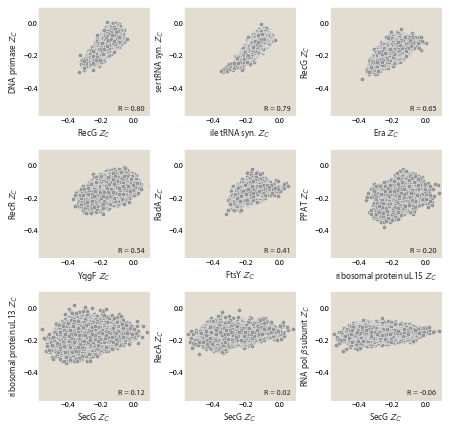

In [6]:
# Same as middle pannel above, but larger, with more examples and with ticks
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7.24, 7.24))
pairs = ["TIGR00643,TIGR01391".split(','), "TIGR00392,TIGR00414".split(','), "TIGR00436,TIGR00643".split(','),
         "TIGR00250,TIGR00615".split(','), "TIGR00064,TIGR00416".split(','), "TIGR01071,TIGR01510".split(','),
         "TIGR00810,TIGR01066".split(','), "TIGR00810,TIGR02012".split(','), "TIGR00810,TIGR02386".split(',')]

pnames_dict = {
    'TIGR00392': 'ile tRNA syn.',
    'TIGR00414': 'ser tRNA syn.',
    'TIGR00810': 'SecG',
    'TIGR02012': 'RecA',
    'TIGR00064': 'FtsY',
    'TIGR00416': 'RadA',
    'TIGR01071': 'RplO',
    'TIGR01510': 'PPAT',  # pantetheine-phosphate adenylyltransferase
    'TIGR00643': 'RecG',
    'TIGR01391': 'DNA primase',
    'TIGR00436': 'Era',
    'TIGR00250': 'YqgF',
    'TIGR00615': 'RecR',
    'TIGR01071': 'ribosomal protein uL15',
    'TIGR01066': 'ribosomal protein uL13',
    'TIGR02386': 'RNA pol $\\beta$ subunit',
}
greys = sns.color_palette('Greys', n_colors=5)
for ax, gene_ids in zip(axs.flatten(), pairs):
    plt.sca(ax)
    sns.scatterplot(data=bac120_nosc_df, x=gene_ids[0], y=gene_ids[1], s=20, color=greys[2])

    desc0 = pnames_dict.get(gene_ids[0], 'gene')
    desc1 = pnames_dict.get(gene_ids[1], 'gene')
    label_fmt = '{0} $Z_C$'
    plt.xlabel(label_fmt.format(desc0), labelpad=3)
    plt.ylabel(label_fmt.format(desc1), labelpad=3)

    corr = nosc_corr_df.loc[gene_ids[0], gene_ids[1]].r
    print(corr, desc0, desc1)
    plt.text(0.95, 0.05, 'R = {0:.2f}'.format(corr), transform=plt.gca().transAxes, ha='right', fontsize=8)
    plt.tick_params(axis='both', which='both', length=0, pad=0)
    plt.xlim(-0.58, 0.1)
    plt.ylim(-0.58, 0.1)
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('../output/Fig4_S1_corr_gallery.png', facecolor='w', dpi=300,  bbox_inches='tight')
plt.show()